In [16]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy

import cgi_phasec_poppy as cgi
reload(cgi)

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [20]:
from emccd_detect.emccd_detect import EMCCDDetect, emccd_detect

meta_path = Path('/home/u21/kianmilani/src/emccd_detect/emccd_detect', 'emccd_detect', 'util', 'metadata.yaml')

dark_current = 0.05*u.electron/u.pix/u.hour

EMCCD = EMCCDDetect(
    em_gain=4.,
    full_well_image=50000.,  # e-
    full_well_serial=90000.,  # e-
    dark_current=dark_current.to_value(u.electron/u.pixel/u.second),  # e-/pix/s
    cic=0.016,  # e-/pix/frame
    read_noise=120.,  # e-/pix/frame
    bias=10000.,  # e-
    qe=0.9,
    cr_rate=5.,  # hits/cm^2/s
    pixel_pitch=13e-6,  # m
    eperdn=7.,
    nbits=14,
    numel_gain_register=604,
    meta_path=meta_path,
)

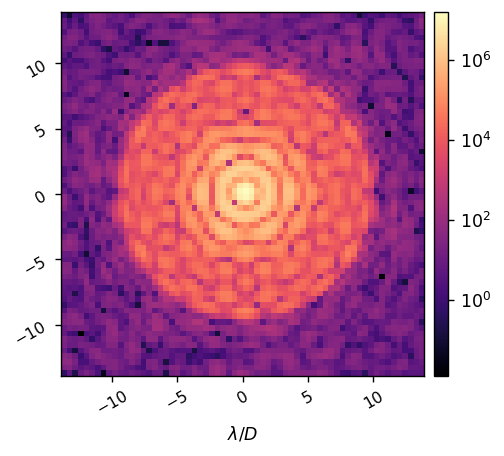

15167884.4713195

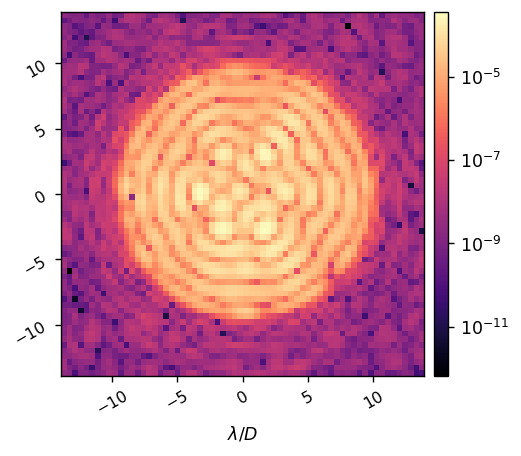

In [43]:
reload(cgi)

source_flux = 2.0208517e8 * u.ph/u.s/u.m**2 # flux of 47 UMa at 575nm with 10% bandpass

c = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=source_flux,
            exp_time=5)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = source_flux/max_ref # divide the source flux to get nominal contrast images
ref_im = c.snap()
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

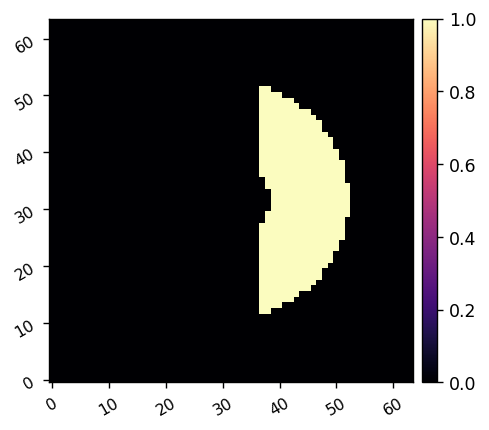

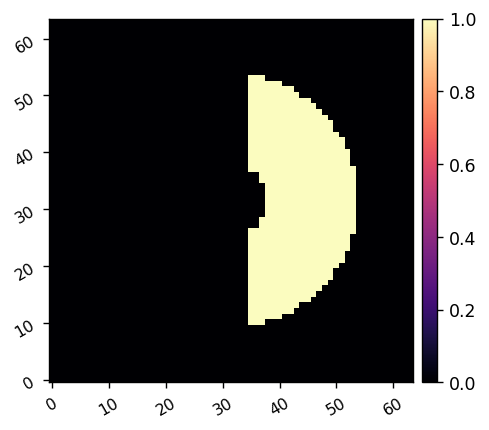

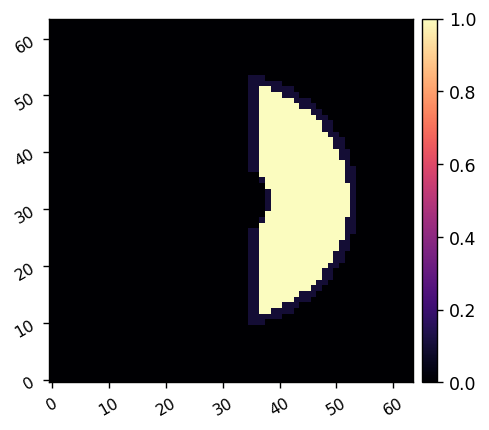

In [39]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 1.5,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

# wfsc.imshow2(roi1, roi2)
weight_map = roi1 + 0.1*(roi2 * ~roi1)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

probe_amp = 3e-8
calib_amp = 5e-9

(476, 2304) (238, 2)


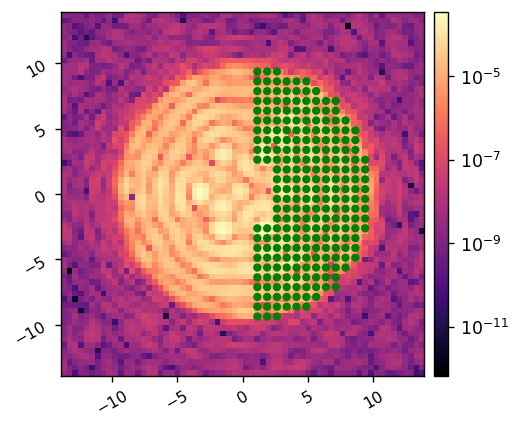

In [44]:
reload(wfsc.utils)
calib_amp = 5e-9
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask, fourier_sampling=0.75) 
nmodes = fourier_modes.shape[0]
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

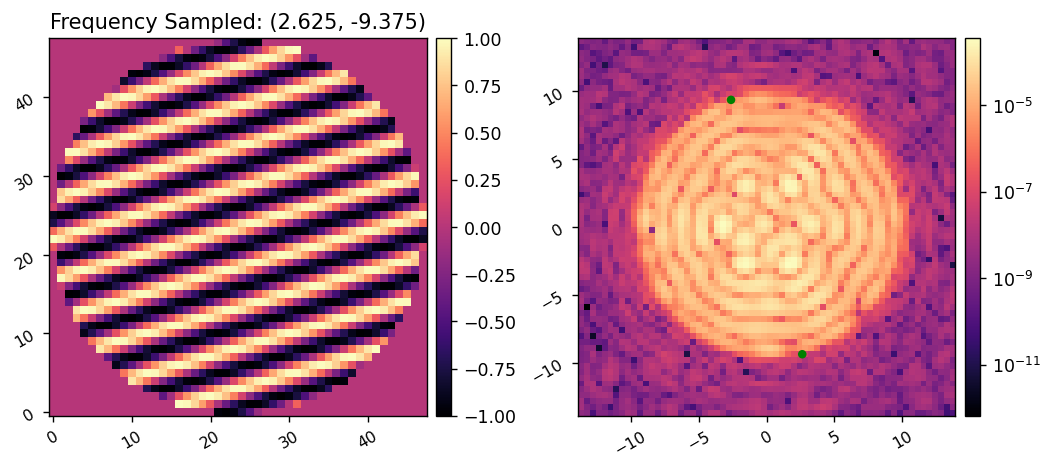

In [25]:
for i in range(fourier_modes.shape[0]//2):
    try:
        wfsc.imshow2(fourier_modes[i].reshape(Nact,Nact), ref_im, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=c.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

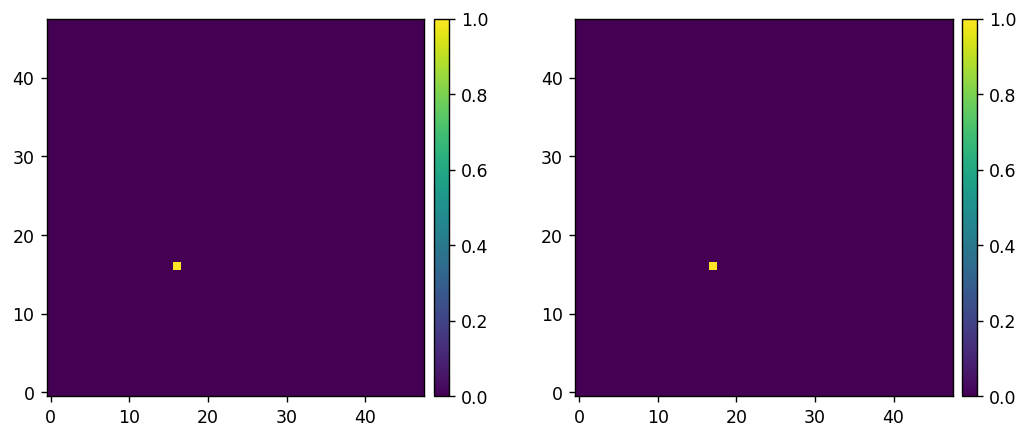

In [41]:
reload(wfsc.utils)
probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//3, Nact//3), (Nact//3+1, Nact//3)], 
                                                 plot=True)

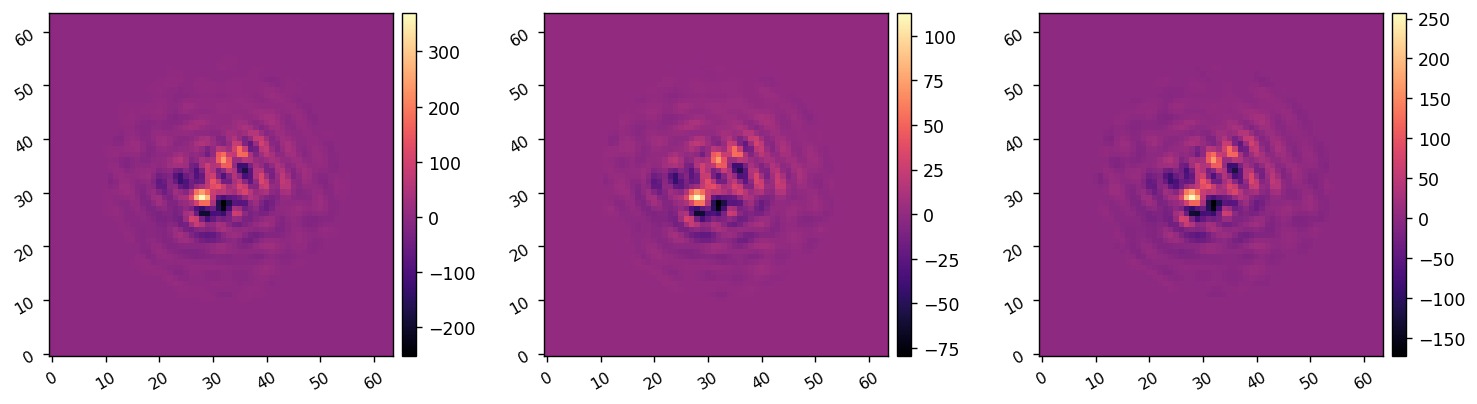

In [45]:
reload(wfsc.iefc)

probe_amp = 3e-8
calib_amp = 5e-9

c.texp = 1
differential_images, single_images = wfsc.iefc_1dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

# Calibrate IEFC (or load in previous calibration data)

In [46]:
reload(wfsc.iefc_1dm)
response_matrix, response_cube = wfsc.iefc_1dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 476 in 2.453s
	Calibrated mode 2 / 476 in 4.903s
	Calibrated mode 3 / 476 in 7.356s
	Calibrated mode 4 / 476 in 9.812s
	Calibrated mode 5 / 476 in 12.262s
	Calibrated mode 6 / 476 in 14.712s
	Calibrated mode 7 / 476 in 17.161s
	Calibrated mode 8 / 476 in 19.607s
	Calibrated mode 9 / 476 in 22.058s
	Calibrated mode 10 / 476 in 24.505s
	Calibrated mode 11 / 476 in 26.957s
	Calibrated mode 12 / 476 in 29.406s
	Calibrated mode 13 / 476 in 31.856s
	Calibrated mode 14 / 476 in 34.312s
	Calibrated mode 15 / 476 in 36.765s
	Calibrated mode 16 / 476 in 39.217s
	Calibrated mode 17 / 476 in 41.668s
	Calibrated mode 18 / 476 in 44.114s
	Calibrated mode 19 / 476 in 46.563s
	Calibrated mode 20 / 476 in 49.012s
	Calibrated mode 21 / 476 in 51.460s
	Calibrated mode 22 / 476 in 53.910s
	Calibrated mode 23 / 476 in 56.356s
	Calibrated mode 24 / 476 in 58.806s
	Calibrated mode 25 / 476 in 61.258s
	Calibrated mode 26 / 476 in 63.709s
	Calibrated mode 27 / 476 in 6

	Calibrated mode 215 / 476 in 528.618s
	Calibrated mode 216 / 476 in 531.090s
	Calibrated mode 217 / 476 in 533.559s
	Calibrated mode 218 / 476 in 536.029s
	Calibrated mode 219 / 476 in 538.492s
	Calibrated mode 220 / 476 in 540.955s
	Calibrated mode 221 / 476 in 543.419s
	Calibrated mode 222 / 476 in 545.882s
	Calibrated mode 223 / 476 in 548.346s
	Calibrated mode 224 / 476 in 550.812s
	Calibrated mode 225 / 476 in 553.276s
	Calibrated mode 226 / 476 in 555.935s
	Calibrated mode 227 / 476 in 558.403s
	Calibrated mode 228 / 476 in 560.862s
	Calibrated mode 229 / 476 in 563.326s
	Calibrated mode 230 / 476 in 565.790s
	Calibrated mode 231 / 476 in 568.263s
	Calibrated mode 232 / 476 in 570.716s
	Calibrated mode 233 / 476 in 573.171s
	Calibrated mode 234 / 476 in 575.626s
	Calibrated mode 235 / 476 in 578.082s
	Calibrated mode 236 / 476 in 580.539s
	Calibrated mode 237 / 476 in 582.991s
	Calibrated mode 238 / 476 in 585.446s
	Calibrated mode 239 / 476 in 587.899s
	Calibrated mode 240 / 47

	Calibrated mode 425 / 476 in 1046.120s
	Calibrated mode 426 / 476 in 1048.589s
	Calibrated mode 427 / 476 in 1051.045s
	Calibrated mode 428 / 476 in 1053.703s
	Calibrated mode 429 / 476 in 1056.160s
	Calibrated mode 430 / 476 in 1058.618s
	Calibrated mode 431 / 476 in 1061.076s
	Calibrated mode 432 / 476 in 1063.530s
	Calibrated mode 433 / 476 in 1065.983s
	Calibrated mode 434 / 476 in 1068.438s
	Calibrated mode 435 / 476 in 1070.899s
	Calibrated mode 436 / 476 in 1073.356s
	Calibrated mode 437 / 476 in 1075.816s
	Calibrated mode 438 / 476 in 1078.271s
	Calibrated mode 439 / 476 in 1080.727s
	Calibrated mode 440 / 476 in 1083.182s
	Calibrated mode 441 / 476 in 1085.635s
	Calibrated mode 442 / 476 in 1088.092s
	Calibrated mode 443 / 476 in 1090.551s
	Calibrated mode 444 / 476 in 1093.005s
	Calibrated mode 445 / 476 in 1095.459s
	Calibrated mode 446 / 476 in 1097.914s
	Calibrated mode 447 / 476 in 1100.369s
	Calibrated mode 448 / 476 in 1102.824s
	Calibrated mode 449 / 476 in 1105.280s


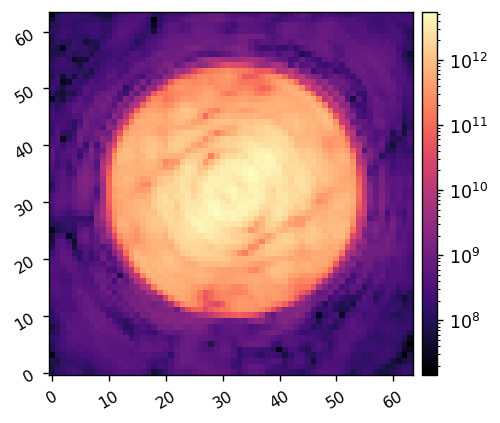

In [47]:
response_sum = xp.sum(abs(response_cube), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)

In [30]:
import misc_funs as misc

misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_response_matrix_20230516.fits', 
               wfsc.utils.ensure_np_array(response_matrix))
misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_response_cube_20230516.fits', 
               wfsc.utils.ensure_np_array(response_cube))

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_response_matrix_20230516.fits
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_response_cube_20230516.fits


In [12]:
response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/'hlc_iefc_response_matrix_20230516.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/'hlc_iefc_response_cube_20230516.fits'))

# Create control matrix

In [32]:
response_matrix.shape

(1372, 532)

Running I-EFC...
	Closed-loop iteration 0 / 20


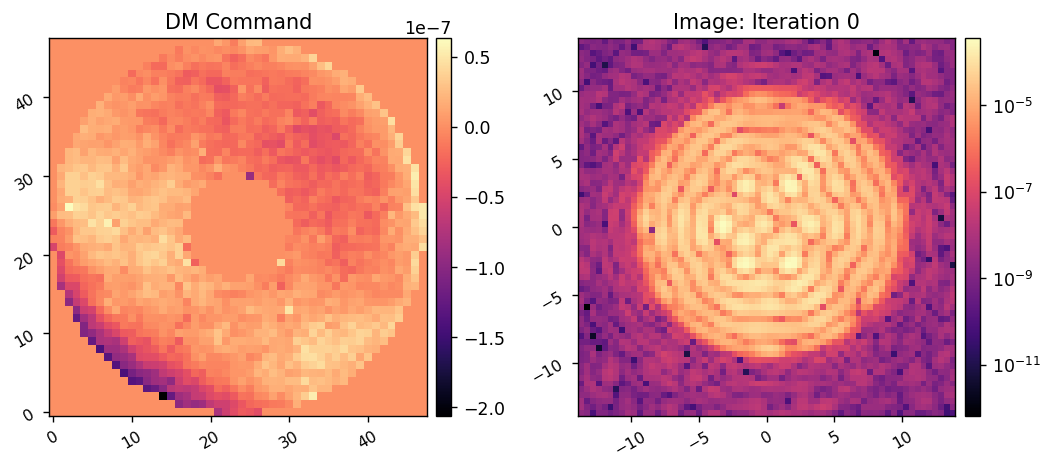

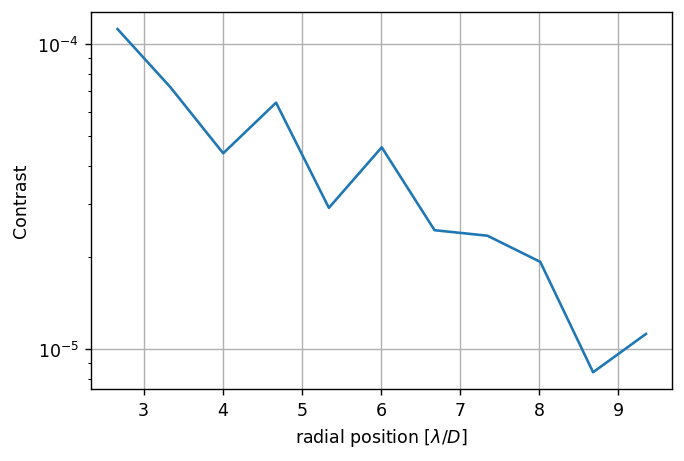

	Closed-loop iteration 1 / 20


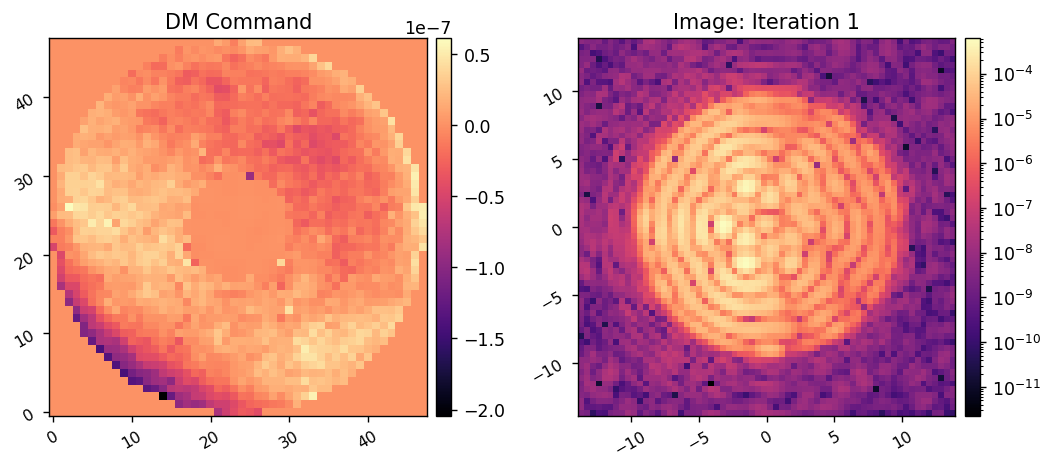

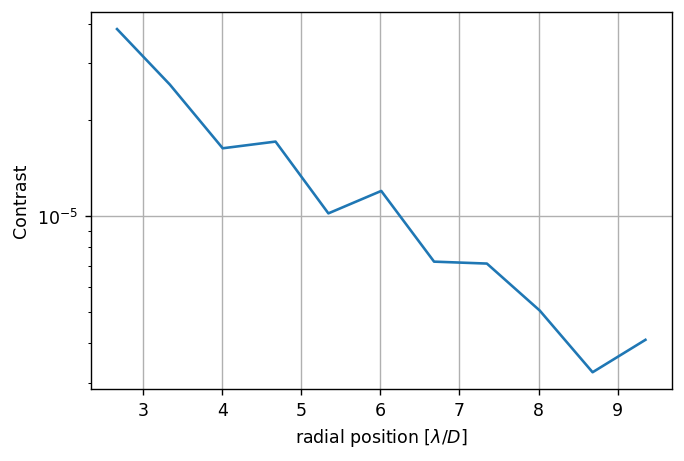

	Closed-loop iteration 2 / 20


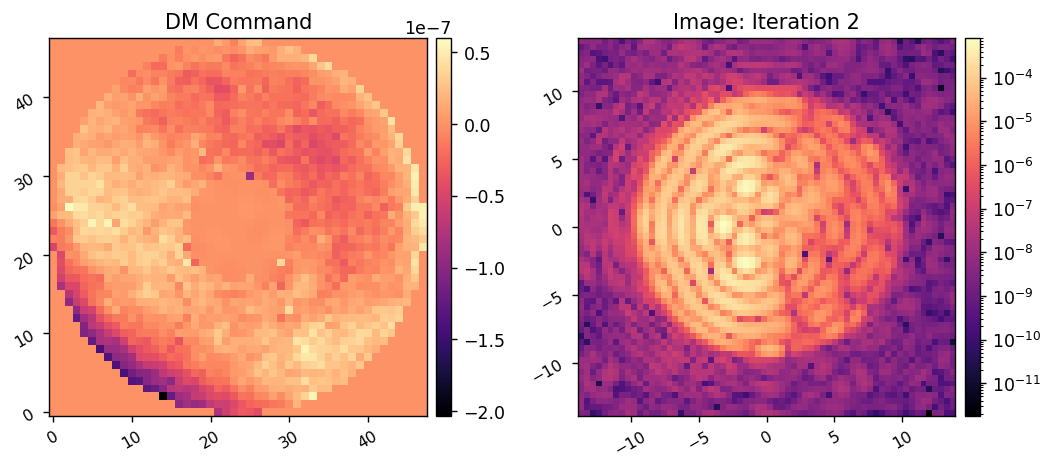

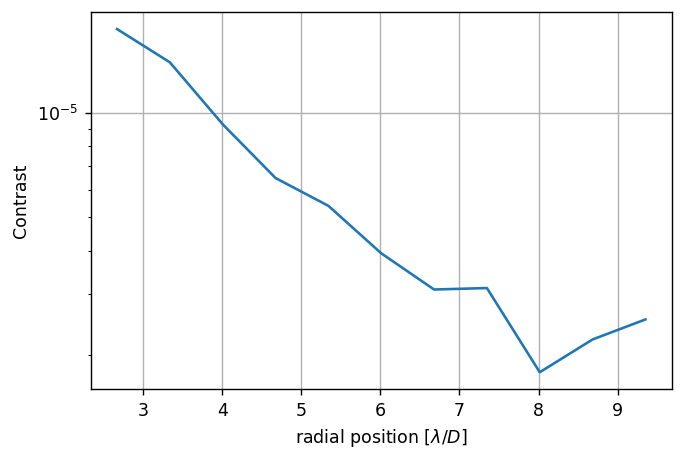

	Closed-loop iteration 3 / 20


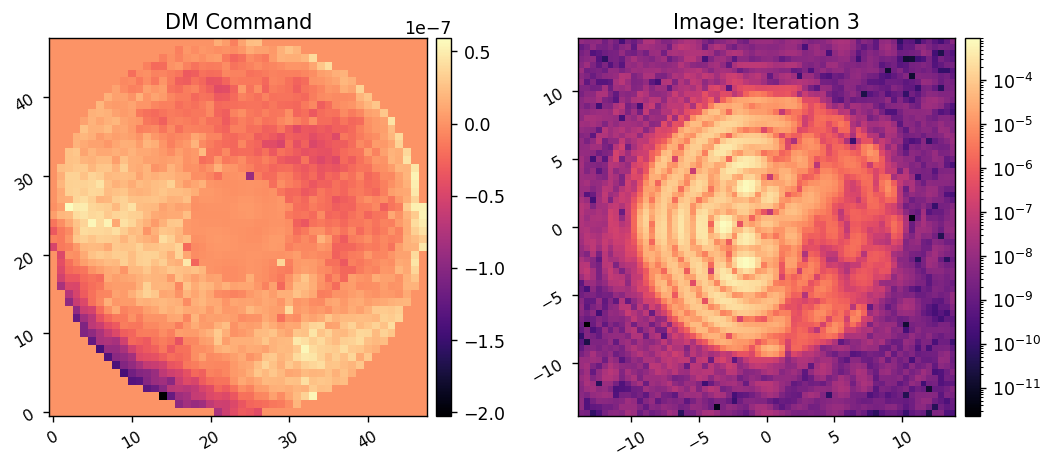

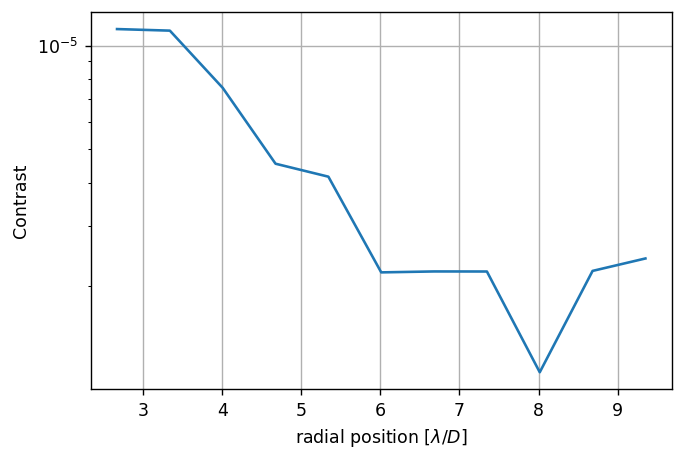

	Closed-loop iteration 4 / 20


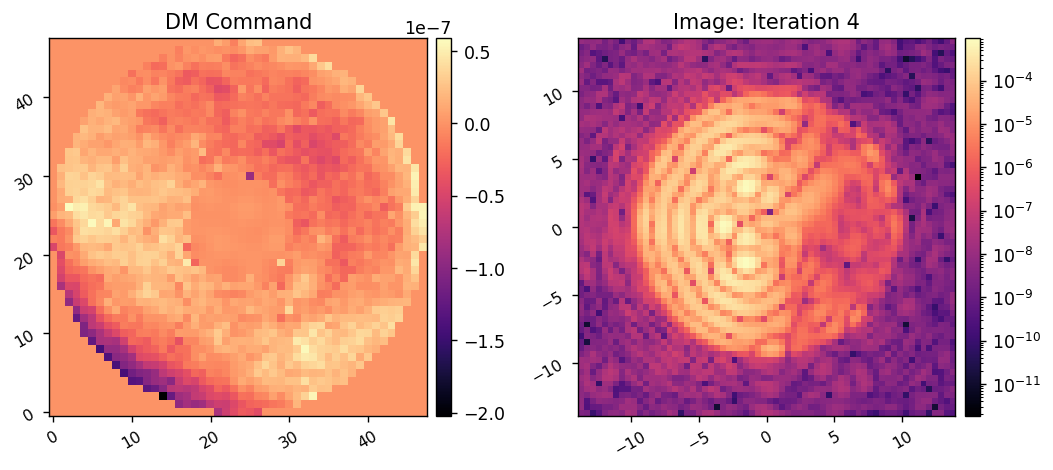

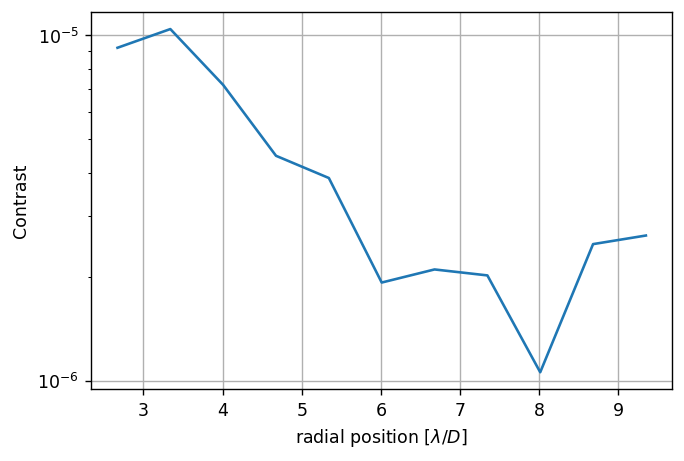

	Closed-loop iteration 5 / 20


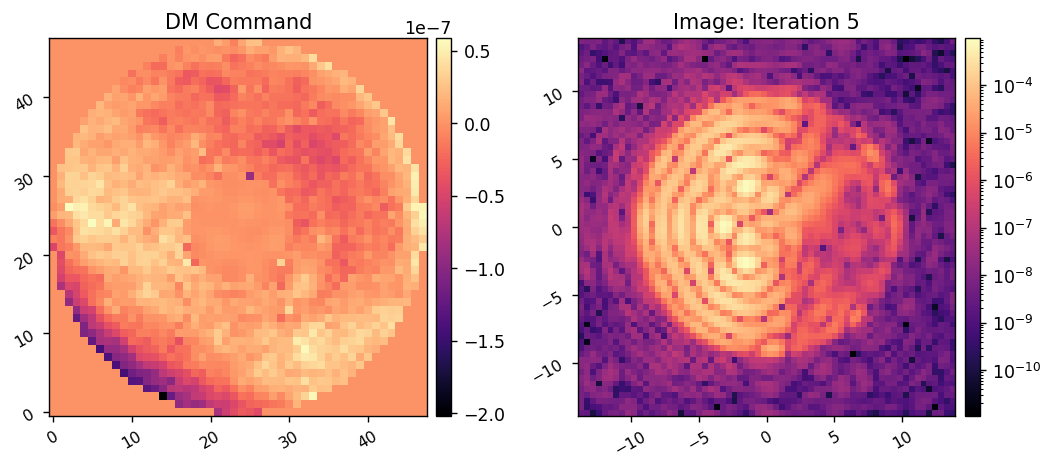

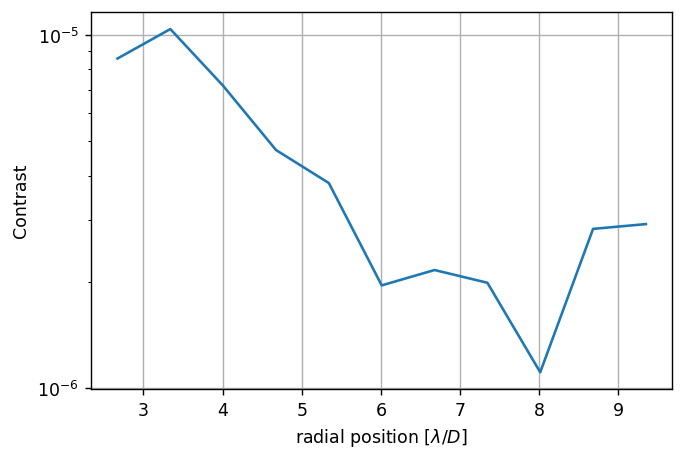

	Closed-loop iteration 6 / 20


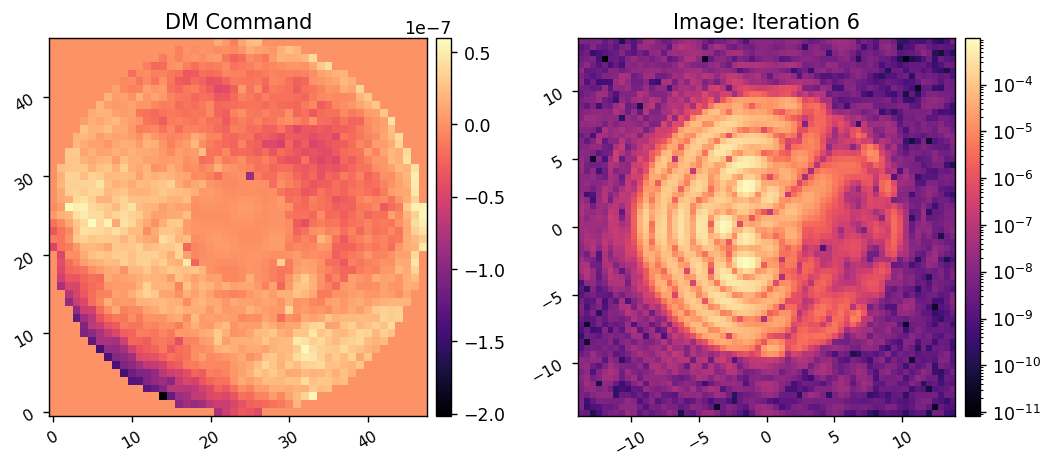

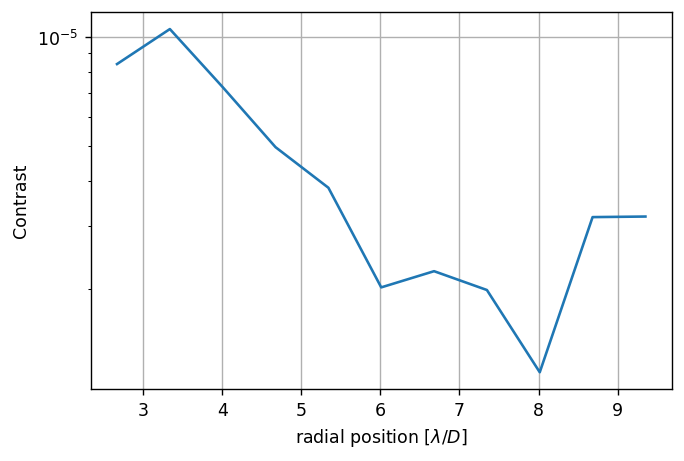

	Closed-loop iteration 7 / 20


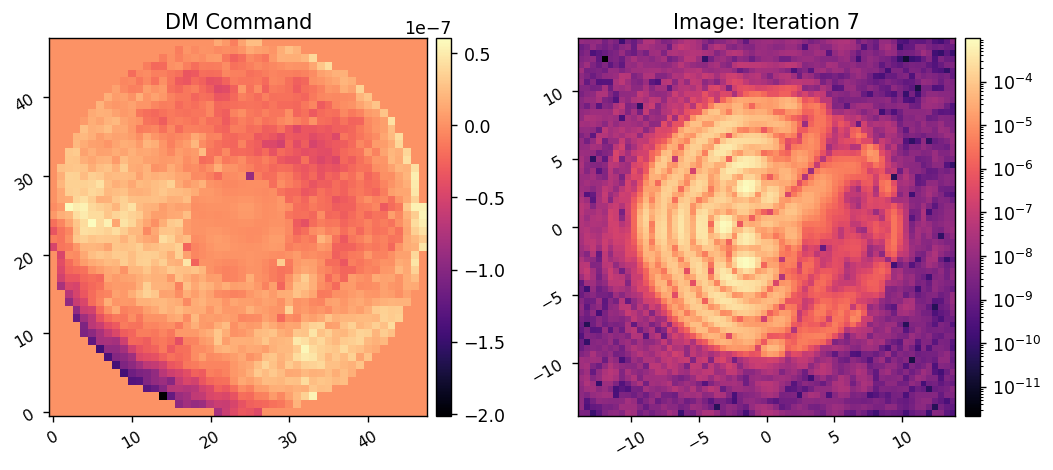

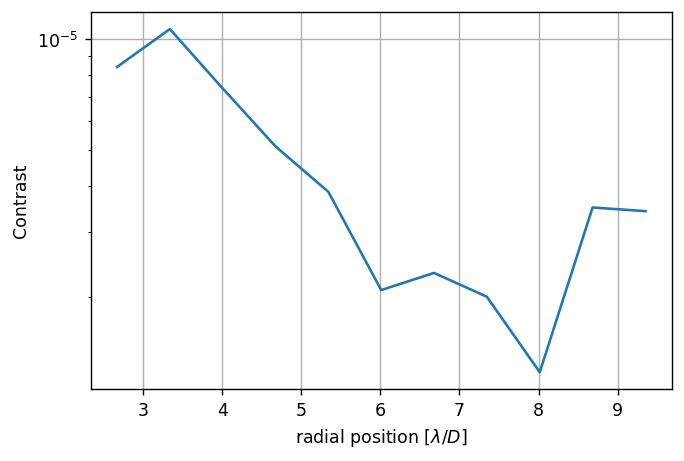

	Closed-loop iteration 8 / 20


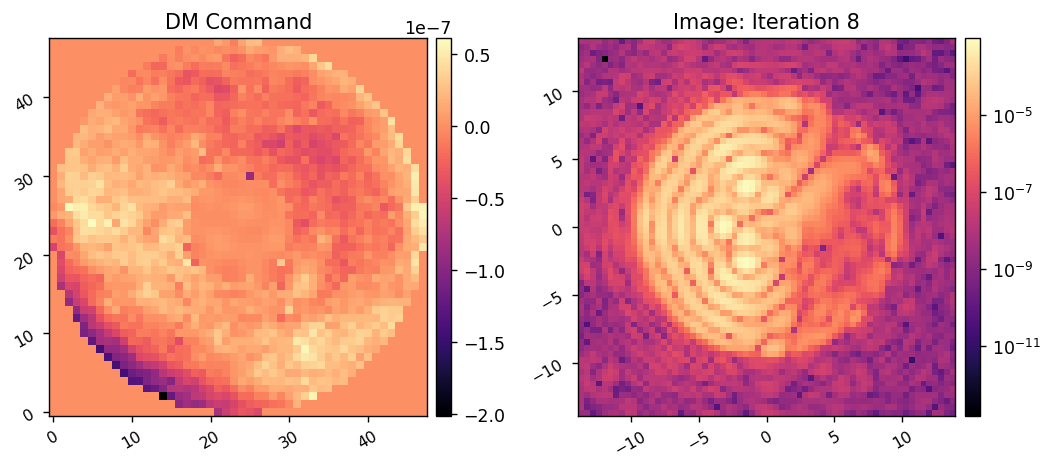

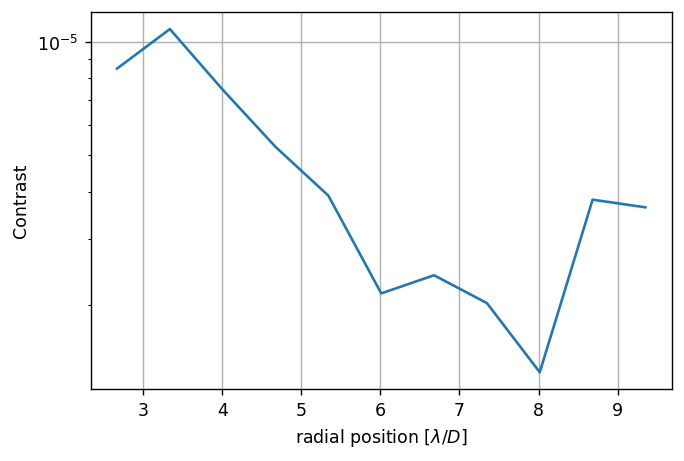

	Closed-loop iteration 9 / 20


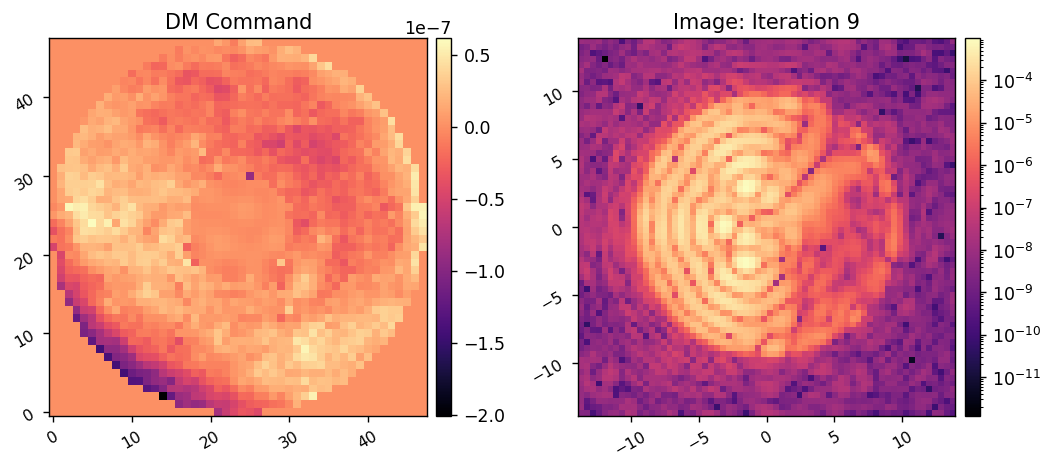

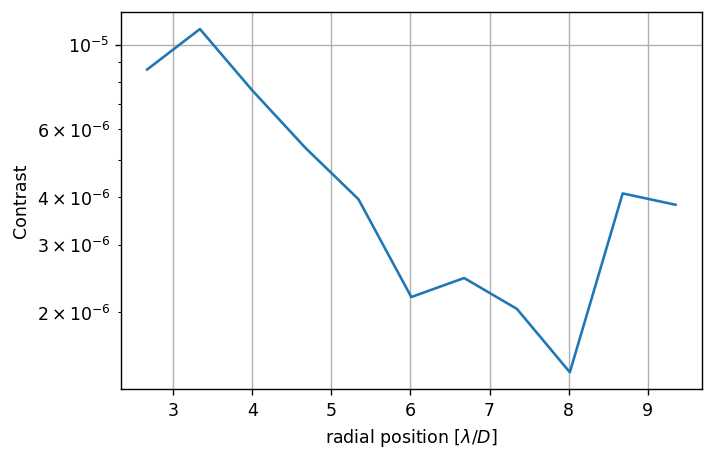

	Closed-loop iteration 10 / 20


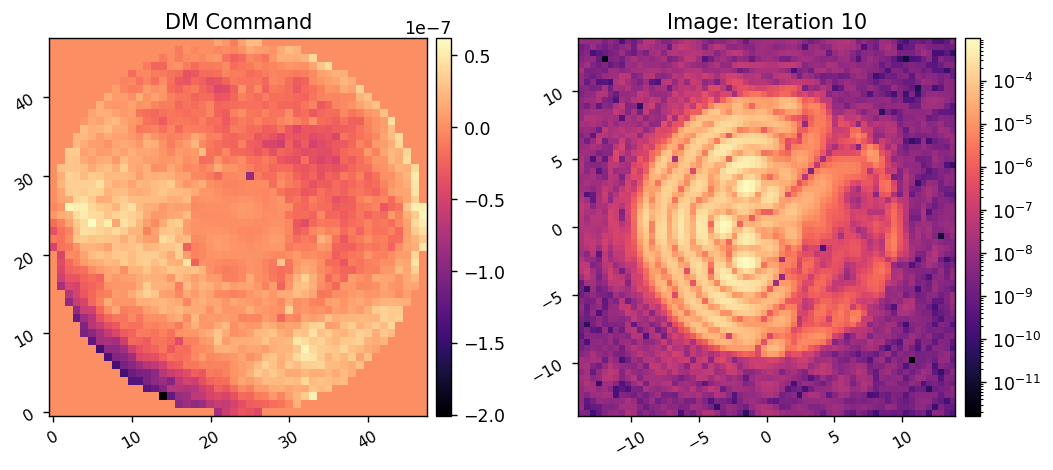

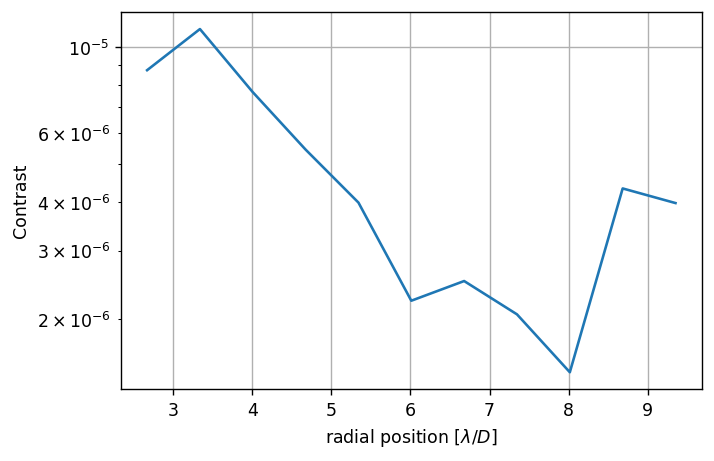

	Closed-loop iteration 11 / 20


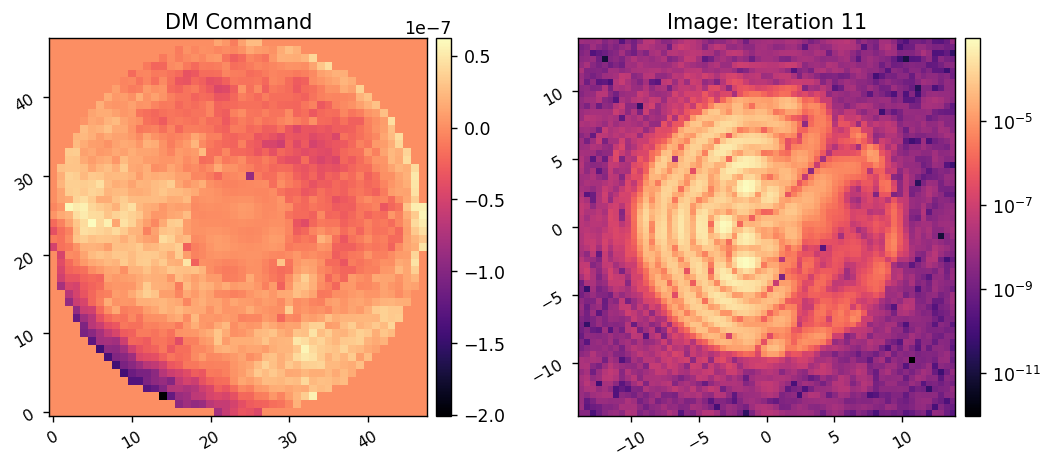

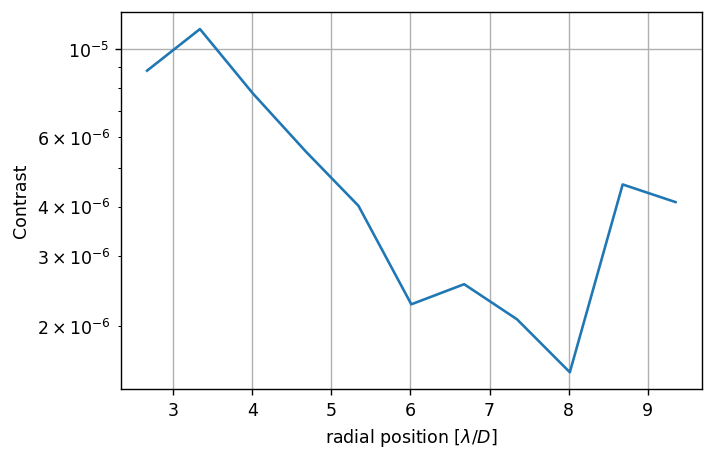

	Closed-loop iteration 12 / 20


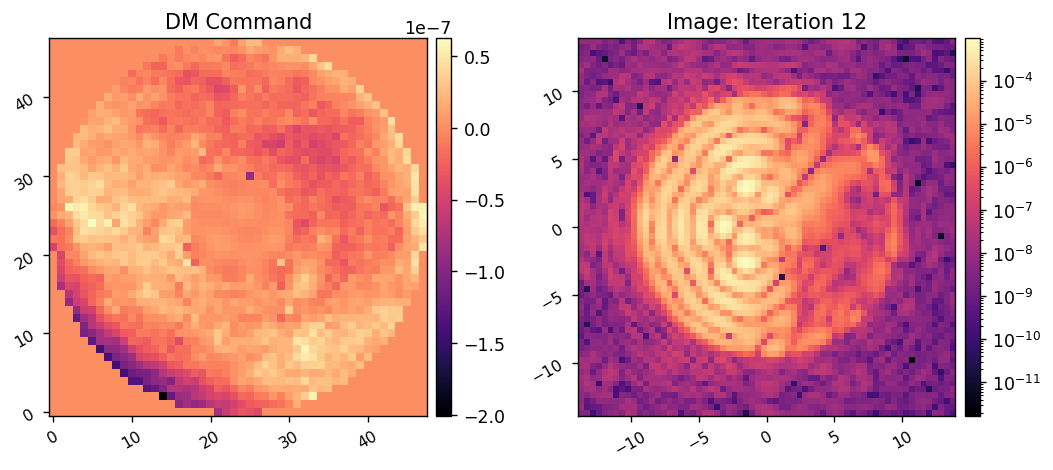

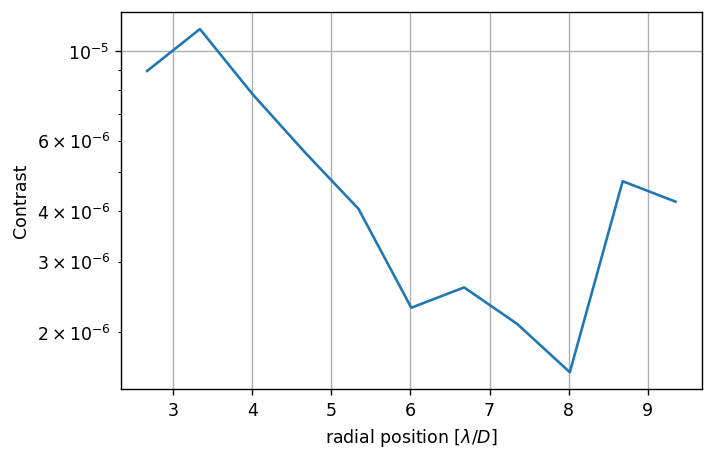

	Closed-loop iteration 13 / 20


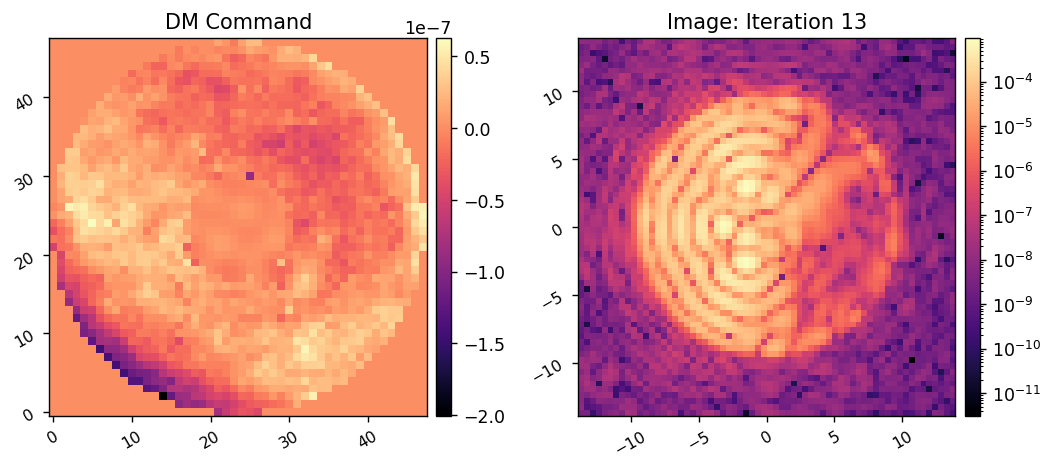

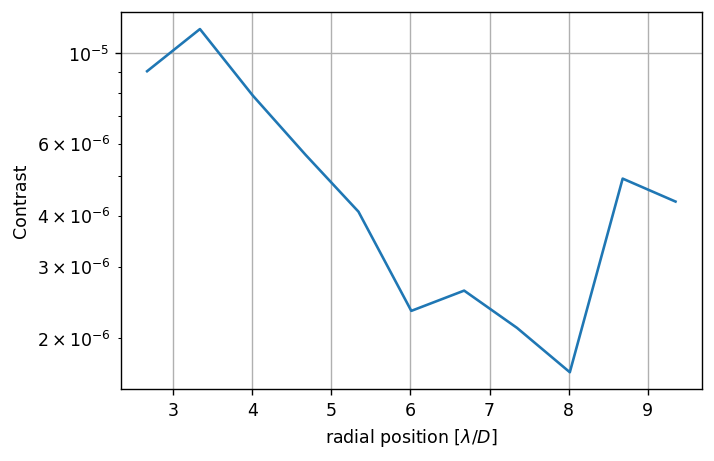

	Closed-loop iteration 14 / 20


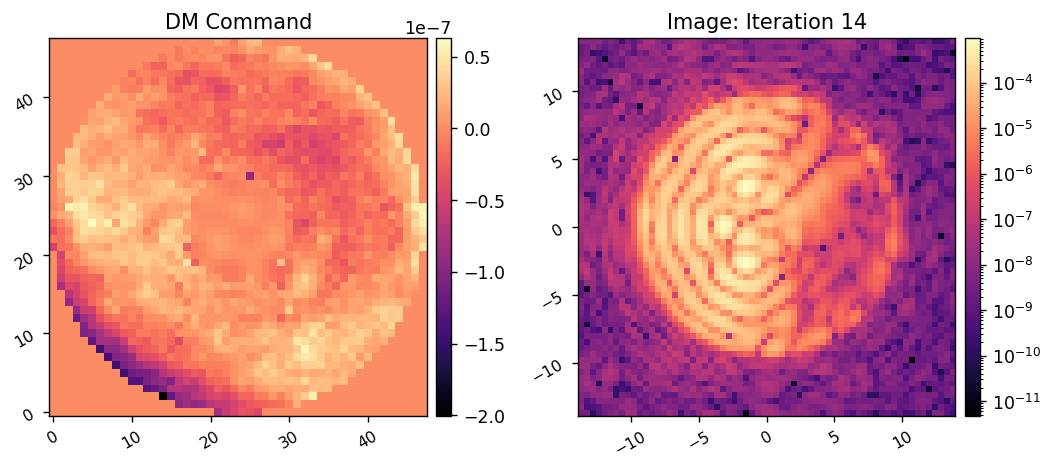

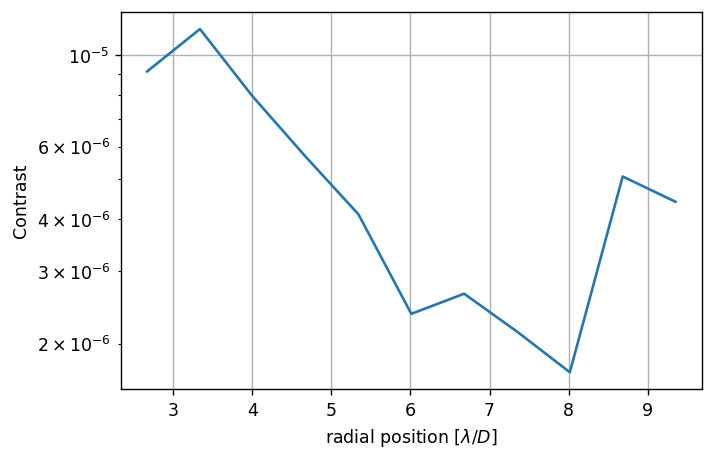

	Closed-loop iteration 15 / 20


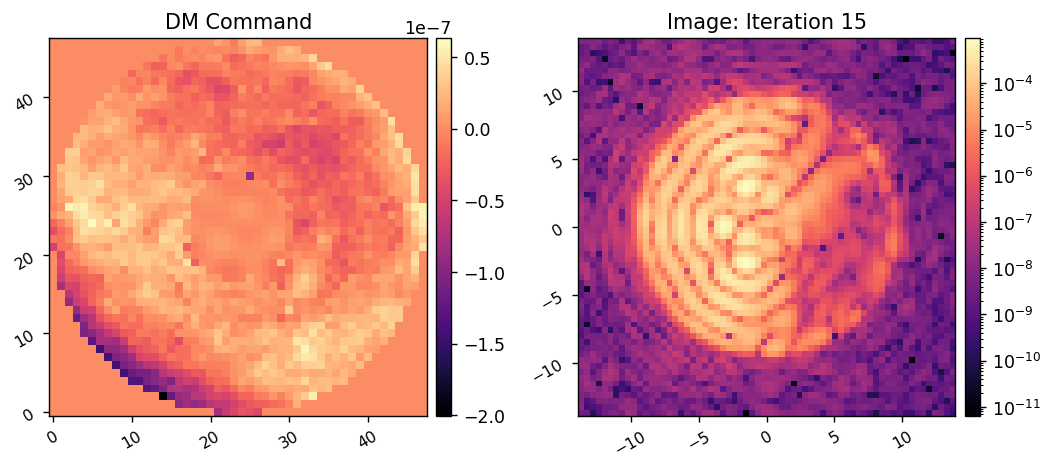

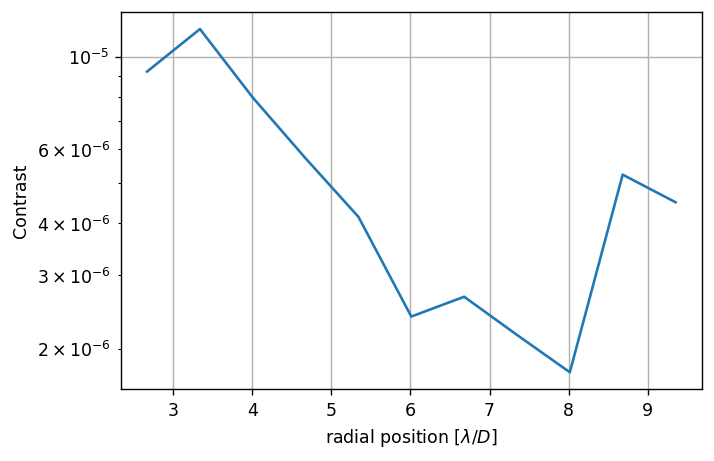

	Closed-loop iteration 16 / 20


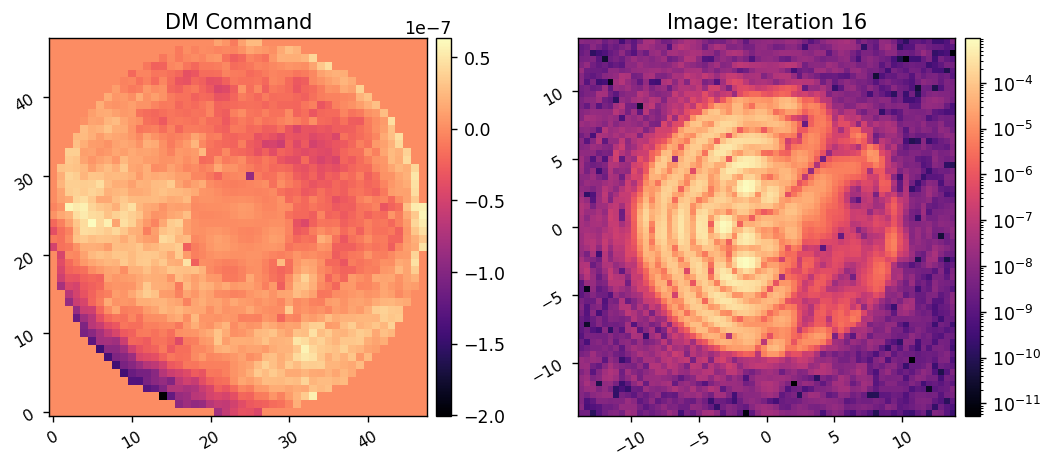

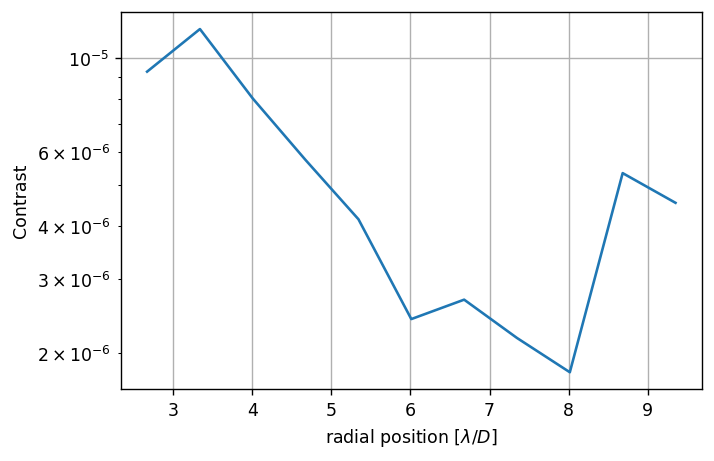

	Closed-loop iteration 17 / 20


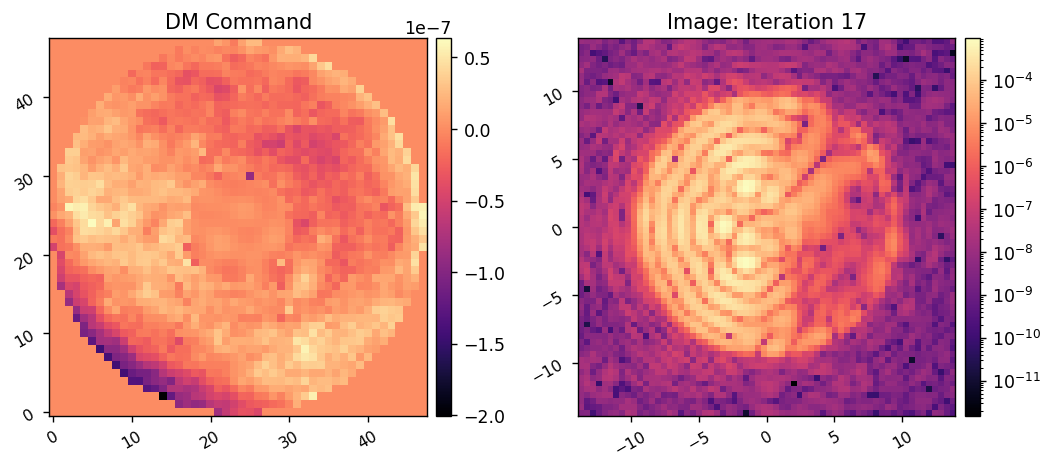

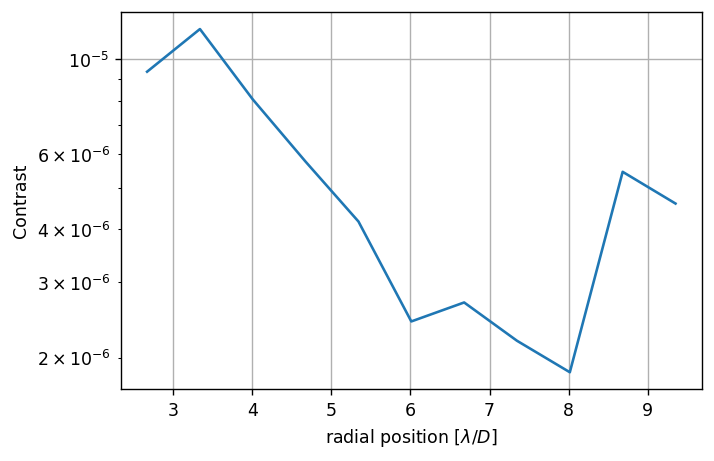

	Closed-loop iteration 18 / 20


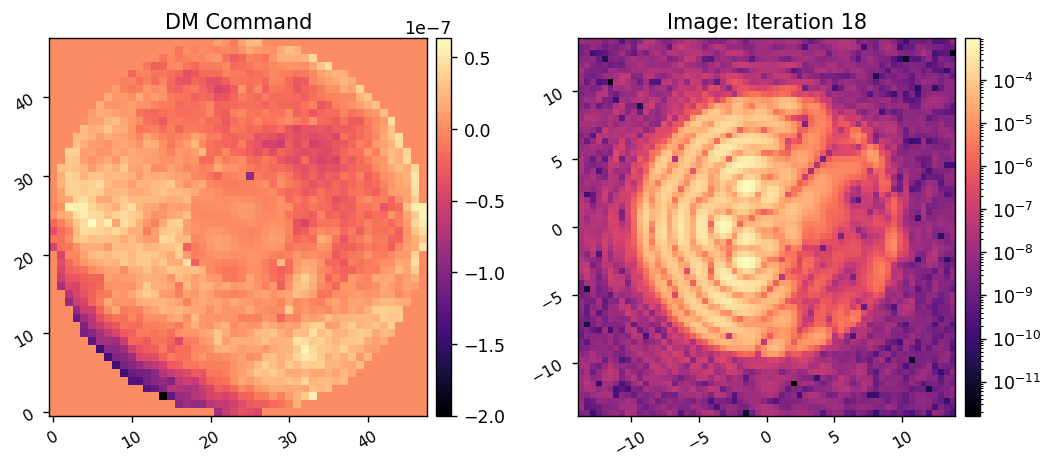

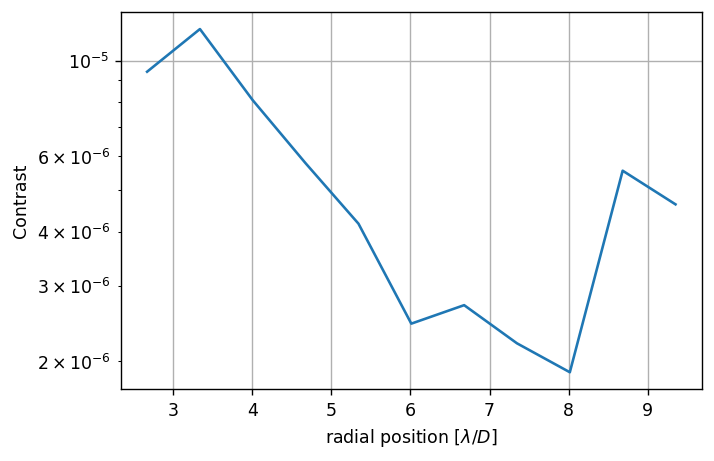

	Closed-loop iteration 19 / 20


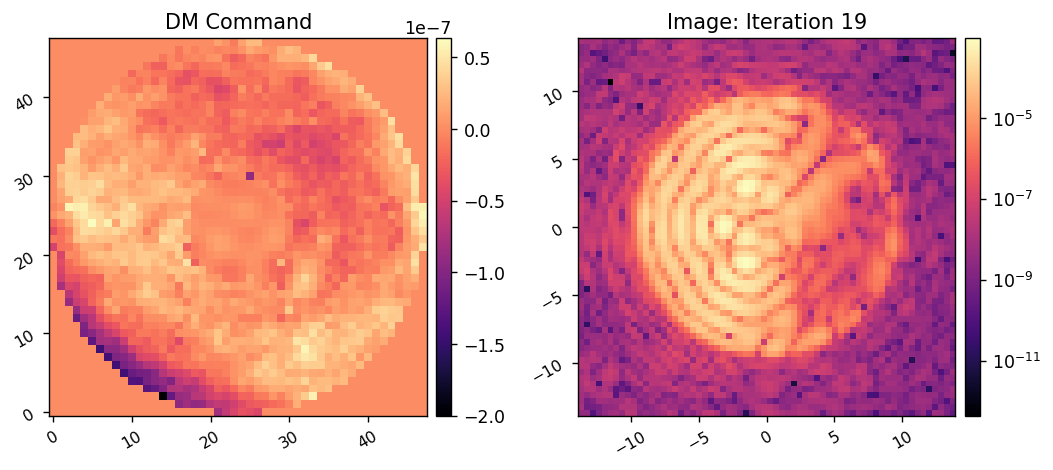

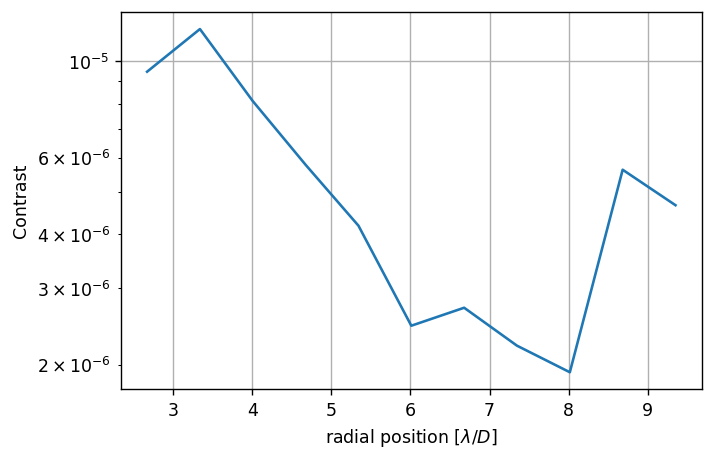

	Closed-loop iteration 20 / 20


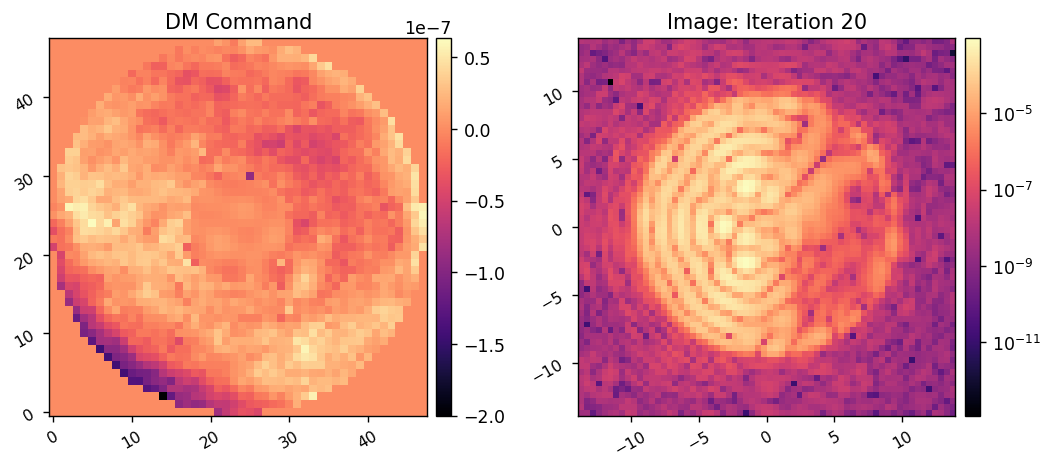

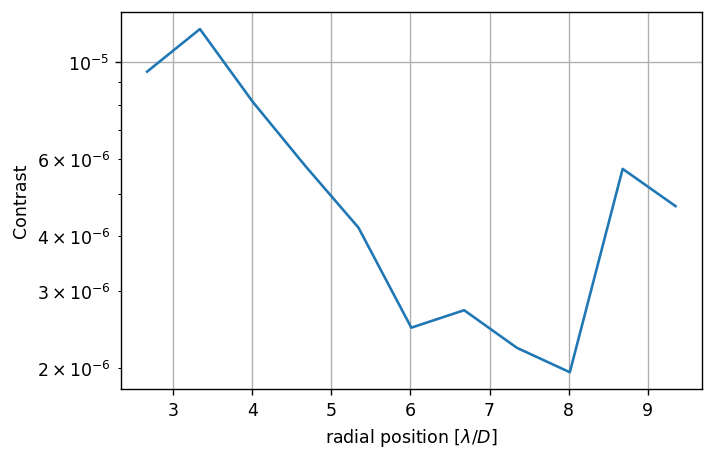

I-EFC loop completed in 49.670s.


In [49]:
reload(wfsc.iefc_1dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-3

cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

images, dm_commands_1 = wfsc.iefc_1dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          fourier_modes,
                                          control_mask, 
                                          num_iterations=20, 
                                          loop_gain=0.5, leakage=0.0,
                                          plot_all=True,
                                         )